In [11]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
import numpy as np
import pandas as pd
from pprint import pprint
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import StratifiedKFold
from scipy import stats
import numpy as np
from sklearn import linear_model, svm
import re
from sklearn.metrics import roc_curve, auc,f1_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
#s = "../braindata/data_1_mor_select_100.csv"
import os          
from sklearn import linear_model, svm
from sklearn.ensemble import ExtraTreesClassifier
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
from sklearn import svm, grid_search
from sklearn.model_selection import GridSearchCV

##read the data and clean data
def data_fetch_clean(file,type):
    #os.getcwd()
    #os.chdir('../braindata')
    dd =pd.read_csv(file,header=0)
    print(dd.shape)
    import csv

    with open(file, 'r') as f:
        d_reader = csv.DictReader(f)

        #get fieldnames from DictReader object and store in list
        headers = d_reader.fieldnames
    data=np.array(dd)
    #print(data.shape)
    idx_IN_columns = np.append(np.array([3,4]),np.array(range(11,data.shape[1])))
    print(idx_IN_columns)
    X=data[:,idx_IN_columns]
    #features=data[:,11:data.shape[1]]
    #features = features.transpose()
    X = stats.zscore(X)
    #print(features.shape)
    y=data[:,type]
    #5: ad-smi / 6:mci-smi / 7:adonly-smi / 8:ad-mci / 9:adonly-mci / 10:adonly - adwithsmallvv


    ind_num=np.isnan(y)
    # print(ind_num.shape)


    y_no_nan = y[~ind_num]

    X_no_nan = X[~ind_num,:]

           # print(y.shape)

    y=y_no_nan
    X=X_no_nan
    feature_num_all=[]
    lr_all_feature=[]
    svm_all_feature=[]
    lr_fls_feature=[]
    svm_fls_feature=[]
    base_labels= []

    np.isnan(X).any()

    X[np.isnan(X)] = np.median(X[~np.isnan(X)])
    return X,y

#classification and cross validation 
def main(X,y,svm_para,lr_para,cv,re,name,n_features):
    logistic = linear_model.LogisticRegression(C=lr_para["C"])
    rbf = svm.SVC(C=svm_para["C"],kernel='linear',gamma=svm_para["gamma"])

    skf=RepeatedStratifiedKFold(n_splits=cv, n_repeats=re)
    lr_all_accs = []
    lr_all_scores = []
    lr_f1s = []
    svm_all_accs = []
    svm_all_scores = []
    svm_f1s = []

    lr_accuracies = []
    lr_scores = []
    svm_accuracies = []
    svm_scores = []
    strat_labels = []


    for train_index, test_index in skf.split(X, y):

            train_data, test_data = X[train_index], X[test_index]
            train_labels, test_labels = y[train_index], y[test_index]
            strat_labels = np.append(strat_labels, test_labels)

            clf = ExtraTreesClassifier(n_estimators=10000, random_state=0)
            clf = clf.fit(train_data, train_labels)
            importances = clf.feature_importances_
            importances
            indices = np.argsort(importances)[::-1]
            #print("Feature ranking:")
            #print(train_labels.shape)
            #for f in range(X.shape[1]):
            #    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
            #n_features = [10,30,50,70,80,100,1000,2000,13000,18000,10000,20000,3000,30000,4000,500,5000,6000,7000,8000,9000,15000,25000]
            #n_features = [1000]
            n_features.sort()



            for i in n_features:


                index=indices[0:i]
                #print(index.shape)
                features=train_data[:,index]

                feature_num=features.shape[1]
                #print(feature_num)


                #train_data, test_data = features[train_index], features[test_index]
                #train_labels, test_labels = y[train_index], y[test_index]


                log = logistic.fit(train_data[:,index], train_labels)
                #print(train_data[:,index].shape)
                log_prob = log.decision_function(test_data[:,index])
                log_acc = log.score(test_data[:,index], test_labels)

                #f1 calculation
                y_pred = logistic.predict(test_data[:,index])
                log_f1 = f1_score(test_labels, y_pred)

                lr_accuracies = np.append(lr_accuracies, log_acc)
                lr_scores = np.append(lr_scores, log_prob)
                lr_f1s = np.append(lr_f1s, log_f1)
                #print('Logistic Regression Accuracy: %f' % log_acc)

                rbf = rbf.fit(train_data[:,index], train_labels)
                svm_acc = rbf.score(test_data[:,index], test_labels)
                svm_prob = rbf.decision_function(test_data[:,index])

                #f1 calculation
                y_pred = rbf.predict(test_data[:,index])
                svm_f1 = f1_score(test_labels, y_pred)
                #print('SVM Accuracy: %f' % svm_acc)
                svm_accuracies = np.append(svm_accuracies, svm_acc)
                svm_scores = np.append(svm_scores, svm_prob)
                svm_f1s = np.append(svm_f1s, svm_f1)
                #print('SVM f1: %f' % svm_f1)


                lr_all_scores = np.append(lr_all_scores, lr_scores)
                lr_fold_avg = np.mean(lr_accuracies)
                lr_all_accs = np.append(lr_all_accs, lr_fold_avg)
                svm_all_scores = np.append(svm_all_scores, svm_scores)
                svm_fold_avg = np.mean(svm_accuracies)
                svm_all_accs = np.append(svm_all_accs, svm_fold_avg)
                #print('Logistic Regression Accuracy: %f' % log_acc_avg)
                #print('SVM Regression Accuracy: %f' % svm_acc_avg)
                #feature_num_all=np.append(feature_num_all,feature_num)
                #print(feature_num_all)
                # print(np.mean(lr_all_accs))
                #print(np.mean(svm_all_accs))      
                #lr_all_feature=np.append(lr_all_feature,np.mean(lr_all_accs))
                ##svm_all_feature=np.append(svm_all_feature,np.mean(svm_all_accs))
                #lr_fls_feature=np.append(lr_fls_feature,np.mean(lr_f1s))
                #svm_fls_feature=np.append(svm_fls_feature,np.mean(svm_f1s))
                #base_labels_all = np.append(base_labels_all,strat)
                #base_labels = np.append(base_labels, np.mean(strat_labels))



    lracc=lr_all_accs.reshape(len(n_features),int(lr_all_accs.shape[0]/23))
    lrcc=np.mean(lracc,axis=1)
    #print(np.max(lracc))
    svmacc=svm_all_accs.reshape(len(n_features),int(lr_all_accs.shape[0]/23))
    svmcc=np.mean(svmacc,axis=1)
    #np.max(svmcc)
   # return lrcc, svmcc,n_features

    import matplotlib.pyplot as plt

    plt.figure()
    plt.plot( (n_features), lrcc*100, lw=5,label='Logistic Regression')
    plt.plot( (n_features), svmcc*100, lw=5,label='SVM')
    plt.xlim([0, 30000])
    plt.ylim([0, 100])
    plt.xlabel('Number of Features')
    plt.ylabel('Accuracy')
    plt.title(name)

    plt.legend(loc="lower right")
    path='../Fig/'+ name+'.pdf'
    print(path)
    plt.savefig(path)
    plt.show()
    return lrcc, svmcc
    
    

In [12]:
def accuracy_roc_save(X,y,lrcc,svmcc,name,cv,re):


    lrindex=np.argmax(lrcc)
    #print("LR Maximum feature number is: {}".format(feature_num_all[lrindex]),file=open("../Fig/MCIvsSMIaccuracy.txt", "a"))
    svmindex=np.argmax(svmcc)
    #print("SVM Maximum feature is number : {}".format(feature_num_all[svmindex]),file=open("../Fig/MCIvsSMIaccuracy.txt", "a"))


    clf = ExtraTreesClassifier(n_estimators=10000,random_state=0)
    clf = clf.fit(X, y)
    importances=clf.feature_importances_
    # # #importances
    indices = np.argsort(importances)[::-1]
    # print("Feature ranking:")

    # for f in range(100):
    #     print("%d. feature %d %s (%f)" % (f + 1, indices[f],headers[indices[f]],importances[indices[f]]),file=open("../Fig/MCIvsSMI_rank.txt", "a"))

    from sklearn import metrics

    max_features = n_features[svmindex]
    #print(max_features)
    lr_all_accs = []
    lr_all_scores = []
    lr_f1s = []
    svm_all_accs = []
    svm_all_scores = []
    svm_f1s = []
    base_labels = []
    lr_sensitivity= []
    svm_sensitivity=[]
    lr_specificity=[]
    svm_specificity=[]

    index=indices[0:int(max_features)]
    features=X[:,index]
    feature_num=features.shape[1]
    for runs in range(1):
        lr_accuracies = []
        lr_scores = []
        svm_accuracies = []
        svm_scores = []
        strat_labels = []

        logistic = linear_model.LogisticRegression(C=lr_para["C"])
        rbf = svm.SVC(C=svm_para["C"],kernel='linear',gamma=svm_para["gamma"])
        from sklearn.metrics import roc_curve, auc,f1_score

        skf=RepeatedStratifiedKFold(n_splits=cv, n_repeats=re)
        for train_index, test_index in skf.split(features, y):
                    train_data, test_data = features[train_index], features[test_index]
                    train_labels, test_labels = y[train_index], y[test_index]
                    #print(train_data.shape)
                    strat_labels = np.append(strat_labels, test_labels)

                    log = logistic.fit(train_data, train_labels)
                    log_prob = log.decision_function(test_data)
                    log_acc = log.score(test_data, test_labels)

                    #f1 calculation
                    y_pred = logistic.predict(test_data)
                    log_f1 = f1_score(test_labels, y_pred)
                    log_confuse= metrics.confusion_matrix(test_labels, y_pred)
                    TP = log_confuse[1, 1]
                    TN = log_confuse[0, 0]
                    FP = log_confuse[0, 1]
                    FN = log_confuse[1, 0]
                    log_sen=metrics.recall_score(test_labels, y_pred)
        #             print(TN)
        #             print(FP)
                    log_spec=TN / (TN + FP)
        #             print(log_confuse)
        #             print(log_sen)
        #             print(log_spec)

                    lr_accuracies = np.append(lr_accuracies, log_acc)
                    lr_sensitivity=np.append(lr_sensitivity, log_sen)
                    lr_specificity=np.append(lr_specificity, log_spec)

                    lr_scores = np.append(lr_scores, log_prob)
                    lr_f1s = np.append(lr_f1s, log_f1)

                    #print('Logistic Regression Accuracy: %f' % log_acc)

                    rbf = rbf.fit(train_data, train_labels)
                    svm_acc = rbf.score(test_data, test_labels)
                    svm_prob = rbf.decision_function(test_data)

                    #f1 calculation
                    y_pred = rbf.predict(test_data)
                    svm_f1 = f1_score(test_labels, y_pred)
                    svm_confuse= metrics.confusion_matrix(test_labels, y_pred)
                    TP = log_confuse[1, 1]
                    TN = log_confuse[0, 0]
                    FP = log_confuse[0, 1]
                    FN = log_confuse[1, 0]
                    svm_sen=metrics.recall_score(test_labels, y_pred)
                    svm_spec=TN / (TN + FP)



                    svm_accuracies = np.append(svm_accuracies, log_acc)
                    svm_sensitivity=np.append(svm_sensitivity, log_sen)
                    svm_specificity=np.append(svm_specificity, log_spec)

                    #print('SVM Accuracy: %f' % svm_acc)
                    svm_accuracies = np.append(svm_accuracies, svm_acc)
                    svm_scores = np.append(svm_scores, svm_prob)
                    svm_f1s = np.append(svm_f1s, svm_f1)

        base_labels = np.append(base_labels, strat_labels)
        lr_all_scores = np.append(lr_all_scores, lr_scores)
        lr_fold_avg = np.mean(lr_accuracies)
        lr_all_accs = np.append(lr_all_accs, lr_fold_avg)
        svm_all_scores = np.append(svm_all_scores, svm_scores)
        svm_fold_avg = np.mean(svm_accuracies)
        svm_all_accs = np.append(svm_all_accs, svm_fold_avg)


    txt_file="../Fig/"+name+"accuracy.txt"
    print("LR accuracy Avg: {}".format(np.mean(lr_accuracies)),file=open(txt_file, "a"))
    print("LR accuracy Standard Deviation: {}".format(np.std(lr_accuracies)),file=open(txt_file, "a"))
    print("LR sensitivity Avg: {}".format(np.mean(lr_sensitivity)),file=open(txt_file, "a"))
    print("LR sensitivity Standard Deviation: {}".format(np.std(lr_sensitivity)),file=open(txt_file, "a"))
    print("LR specificity Avg: {}".format(np.mean(lr_specificity)),file=open(txt_file, "a"))
    print("LR specificity Standard Deviation: {}".format(np.std(lr_specificity)),file=open(txt_file, "a"))
    print("LR f1s Avg : {}".format(np.mean(lr_f1s)),file=open(txt_file, "a"))
    print("LR f1s Standard Deviation: {}".format(np.std(lr_f1s)),file=open(txt_file, "a"))

    print("SVM Avg: {}".format(np.mean(svm_accuracies)),file=open(txt_file, "a"))
    print("SVM Standard Deviation: {}".format(np.std(svm_accuracies)),file=open(txt_file, "a"))
    print("SVM sensitivity Avg: {}".format(np.mean(svm_sensitivity)),file=open(txt_file, "a"))
    print("SVM sensitivity Standard Deviation: {}".format(np.std(svm_sensitivity)),file=open(txt_file, "a"))
    print("SVM specificity Avg: {}".format(np.mean(svm_specificity)),file=open(txt_file, "a"))
    print("SVM specificity Standard Deviation: {}".format(np.std(svm_specificity)),file=open(txt_file, "a"))
    print("SVM f1s Avg : {}".format(np.mean(svm_f1s)),file=open(txt_file, "a"))
    print("SVM f1s Standard Deviation: {}".format(np.std(svm_f1s)),file=open(txt_file, "a"))
    #lrindex=np.argmax(lr_all_feature)
    # print("LR Maximum feature number is: {}".format(feature_num_all[lrindex]),file=open(txt_file, "a"))
    #svmindex=np.argmax(svm_all_feature)
    # print("SVM Maximum feature is number : {}".format(feature_num_all[svmindex]),file=open(txt_file, "a"))

    ###############################################################################################################

    from sklearn.metrics import roc_curve, auc,f1_score
    import matplotlib.pyplot as plt

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    fpr['lr'], tpr['lr'], _ = roc_curve(base_labels, lr_all_scores)
    roc_auc['lr'] = auc(fpr['lr'], tpr['lr'])
    #f1['lr']=f1_score(fpr['lr'], tpr['lr'])
    fpr['svm'], tpr['svm'], _ = roc_curve(base_labels, svm_all_scores)
    roc_auc['svm'] = auc(fpr['svm'], tpr['svm'])
    #f1['svm']=f1_score(fpr['svm'], tpr['svm'])
    #fpr['gcn'], tpr['gcn'], _ = roc_curve(all_labels, all_scores)
    #roc_auc['gcn'] = auc(fpr['gcn'], tpr['gcn'])

    plt.figure()
    plt.plot(fpr['lr'], tpr['lr'], lw=5, label='Logistic Regression (area = %0.2f)' % roc_auc['lr'] )
    #plt.plot(fpr['lr'], tpr['lr'], lw=3, label='Logistic Regression (f1 = %0.2f)' % f1['lr'] )

    plt.plot(fpr['svm'], tpr['svm'], lw=5, label='SVM (area = %0.2f)' % roc_auc['svm'] )
    #plt.plot(fpr['svm'], tpr['svm'f], lw=3, label='SVM (f1 = %0.2f)' % f1['svm'] )
    #plt.plot(fpr['gcn'], tpr['gcn'], lw=3, label='GCN (area = %0.2f)' % roc_auc['gcn'])
    plt.plot([0, 1], [0, 1], color='navy', lw=5, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(name)
    plt.legend(loc="lower right") 
    #plt.savefig('10x_Combined_ROC.eps')
    #plt.savefig('ROC_MCIVsNormal_connectome.eps')
    #plt.show()
    roc_path="../Fig/ROC_"+name+"_connectome.pdf"
    plt.savefig(roc_path)

In [13]:
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='linear'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

def lr_param_selection(X, y, nfolds):
    Cs = [1000,10000,10e5,10e6]
    # gammas = [0.001, 0.01, 0.1, 1] 
    param_grid = {'C': Cs}
    grid_search = GridSearchCV(linear_model.LogisticRegression(), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

(208, 34657)
[    3     4    11 ..., 34654 34655 34656]


/Users/posnerlab/Library/Python/3.5/lib/python/site-packages/scipy/stats/stats.py:2247: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


../Fig/MCI vs SMC.pdf


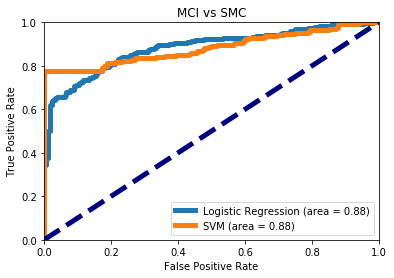

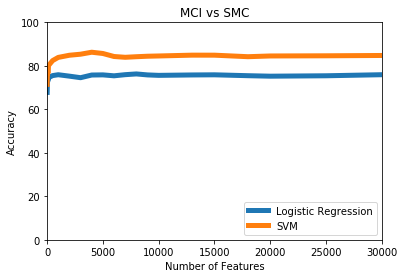

In [14]:
cwd=os.getcwd()
os.chdir('../braindata')
#filename="data_2_conn.csv"
filename="data_3_all.csv"
n_features = [10,30,50,70,80,100,1000,2000,13000,18000,10000,20000,3000,30000,4000,500,5000,6000,7000,8000,9000,15000,25000]

save_name=["AD vs SMC","MCI vs SMC","ADonly vs SMC","AD vs MCI","ADonly vs MCI","ADonly vs ADwithsmallvv"]
for i in range(6,7):

    X,y=data_fetch_clean(filename,i)

    #5: ad-smi / 6:mci-smi / 7:adonly-smi / 8:ad-mci / 9:adonly-mci / 10:adonly - adwithsmallvv
    name=save_name[i-5]
    svm_para=svc_param_selection(X,y,10)
    lr_para=lr_param_selection(X,y,10)
    
    # this is the main function 
    lrcc,svmcc=main(X,y,svm_para,lr_para,10,10,name,n_features) # 10 fold, repeat number, and the name to save; 
    accuracy_roc_save(X,y,lrcc,svmcc,name,10,10)
    

In [99]:
accuracy_roc_save(X,y,lrcc,svmcc,name,10,10)
